(notebook:illustrative)=

# The Method of Moderation: Illustrative Notebook

In [1]:
# Import Econ-ARK styling and display header
from style import (
    HEADER_HTML_NOTEBOOK,
    apply_ark_style,
    apply_notebook_css,
)

# Apply Econ-ARK branding and styling
apply_ark_style()
apply_notebook_css()


# Display Econ-ARK header (for Jupyter notebooks)
from IPython.display import HTML, display

display(HTML(HEADER_HTML_NOTEBOOK))

**Author:** <span style="color: var(--ark-lightblue); font-weight: bold;">Alan Lujan</span>, <span style="color: var(--ark-blue); font-weight: bold;">Johns Hopkins University</span>

This notebook provides a pedagogical introduction to the Method of Moderation (MoM), a novel technique for solving consumption-saving models with superior accuracy and stability. We begin by motivating the problem that MoM solves—the "extrapolation problem" inherent in sparse-grid implementations of the Endogenous Grid Method (EGM). We then build the theoretical foundations for MoM, demonstrating how it leverages analytical bounds to ensure economically sensible behavior across the entire state space.

## Model Foundations: The Friedman-Muth Income Process

To understand the consumption-saving problem, we must first define the economic environment. We adopt the canonical framework of an agent who receives a stream of labor income that is subject to both permanent and transitory shocks. This income process, first conceptualized by {cite:t}`Friedman1957` and later formalized stochastically by {cite:t}`Muth1960`, provides a realistic foundation for modeling household financial behavior. It captures two key features of real-world income dynamics:

* **Permanent Shocks**: Unexpected changes to lifetime earning potential (e.g., a promotion or a permanent disability).
* **Transitory Shocks**: Temporary fluctuations in income (e.g., a one-time bonus or a temporary layoff).

The model used in this notebook, drawn from {cite:t}`SolvingMicroDSOPs`, implements this income process and provides the basis for solving the consumer's optimization problem.

## The Extrapolation Problem in Consumption-Saving Models

At its core, the Method of Moderation (MoM) is designed to solve a persistent challenge in computational economics: the **extrapolation problem**. This issue is particularly pronounced in sparse-grid implementations of the Endogenous Grid Method (EGM), a widely-used technique for solving dynamic stochastic optimization problems.

When EGM is used to solve a consumption-saving model, it computes the optimal consumption policy at a finite set of grid points. However, to simulate agent behavior or analyze policy implications, we often need to evaluate the consumption function at points that lie outside this pre-computed grid. Standard practice is to extrapolate from the grid, but this can lead to results that violate fundamental economic theory. Specifically, linear extrapolation can predict **negative precautionary saving**, which implies that consumers with greater income uncertainty would save *less* than those with no uncertainty—a direct contradiction of established economic principles {cite:p}`Leland1968,Sandmo1970,Kimball1990`.

MoM addresses this problem by abandoning direct extrapolation of the consumption function. Instead, it operates in a transformed space defined by two analytical, theoretically-grounded bounds. This approach builds on a long literature on "buffer-stock" saving behavior {cite:p}`Carroll1997`, which has established theoretical properties of consumption functions under uncertainty {cite:p}`StachurskiToda2019JET,MST2020JET`. The two bounds are:

1. **The Optimist's Solution**: A consumer who ignores all future income risk.
2. **The Pessimist's Solution**: A consumer who assumes the worst possible income realization in all future periods.

The true, "realist" consumption function must lie between these two extremes. MoM respects this by interpolating a **moderation ratio** that is guaranteed to remain within these bounds. The result is a consumption function that is not only computationally efficient but also economically coherent across the entire state space.

**Key Insight**: By transforming the problem into a space defined by theoretical bounds, MoM ensures that its solutions are always economically sensible, even far outside the computed grid. This notebook will walk through the practical implementation of this insight, from demonstrating the EGM's extrapolation failure to building the MoM solution step-by-step.

In [2]:
from __future__ import annotations

from moderation import (
    IndShockEGMConsumerType,
    IndShockMoMConsumerType,
)
from plotting import (
    GridType,
    plot_consumption_bounds,
    plot_logit_function,
    plot_moderation_ratio,
    plot_mom_mpc,
    plot_precautionary_gaps,
    plot_value_functions,
)

# Model setup: Consumer with income uncertainty
params = {
    "CRRA": 2.0,
    "DiscFac": 0.96,
    "Rfree": [1.02],
    "TranShkStd": [1.0],
    "cycles": 1,
    "LivPrb": [1.0],
    "vFuncBool": True,
    "CubicBool": True,
    "PermGroFac": [1.0],
    "PermShkStd": [0.0],
    "TranShkCount": 7,
    "UnempPrb": 0.0,
    "BoroCnstArt": None,
}

# Dense grid for "truth" solution (high precision)
dense_grid = {"aXtraMin": 0.001, "aXtraMax": 40, "aXtraCount": 500, "aXtraNestFac": 3}

# Sparse grid for practical comparison (5 points only)
sparse_grid = {"aXtraMin": 0.001, "aXtraMax": 4, "aXtraCount": 5, "aXtraNestFac": -1}

# Solve three versions: Truth (dense EGM), Sparse EGM, Sparse MoM
IndShockTruth = IndShockEGMConsumerType(**(params | dense_grid))
IndShockTruth.solve()
IndShockTruthSol = IndShockTruth.solution[0]

# Unpack theoretical bounds (same for all methods)
TruthOpt = IndShockTruthSol.Optimist
TruthPes = IndShockTruthSol.Pessimist
TruthTight = IndShockTruthSol.TighterUpperBound

# Sparse EGM solution (standard approach)
IndShockEGMApprox = IndShockEGMConsumerType(**(params | sparse_grid))
IndShockEGMApprox.solve()
IndShockEGMApproxSol = IndShockEGMApprox.solution[0]

# Sparse MoM solution (same grid, different method)
IndShockMoMApprox = IndShockMoMConsumerType(**(params | sparse_grid))
IndShockMoMApprox.solve()
IndShockMoMApproxSol = IndShockMoMApprox.solution[0]

# Grid parameters for plotting
mNrmMax = IndShockMoMApproxSol.mNrmMin + IndShockMoMApprox.aXtraGrid.max()

## Consumption Function Analysis

The first set of figures will focus on the core of the consumption-saving problem: the consumption function, $c(m)$, which maps market resources, $m$, to a chosen level of consumption. We will demonstrate the extrapolation problem inherent in the standard EGM and show how the Method of Moderation resolves it by respecting theoretical bounds.

### Figure 1: The EGM Extrapolation Problem

At the heart of any numerical solution to a consumption-saving problem lies the challenge of **extrapolation**. Because we can only compute the solution at a finite number of points, we must have a reliable way to evaluate the policy function at points outside this grid. Economic theory provides a powerful test of any method's extrapolation properties: the **precautionary saving gap**.

This gap, defined as the difference between the consumption of a perfect-foresight "optimist" and that of a "realist" facing uncertainty, should always be positive. The presence of uninsurable income risk should lead consumers to save more (and thus consume less) than they would in a certain world. However, as {ref}`demonstrated in the paper <benchmark-the-method-of-endogenous-gridpoints>` and illustrated in [](#fig:egm-extrapolation-problem) (which corresponds to {ref}`Figure 1 <fig:ExtrapProblem>` in the academic paper), standard EGM struggles with this constraint when extrapolating {cite:p}`carrollEGM`.

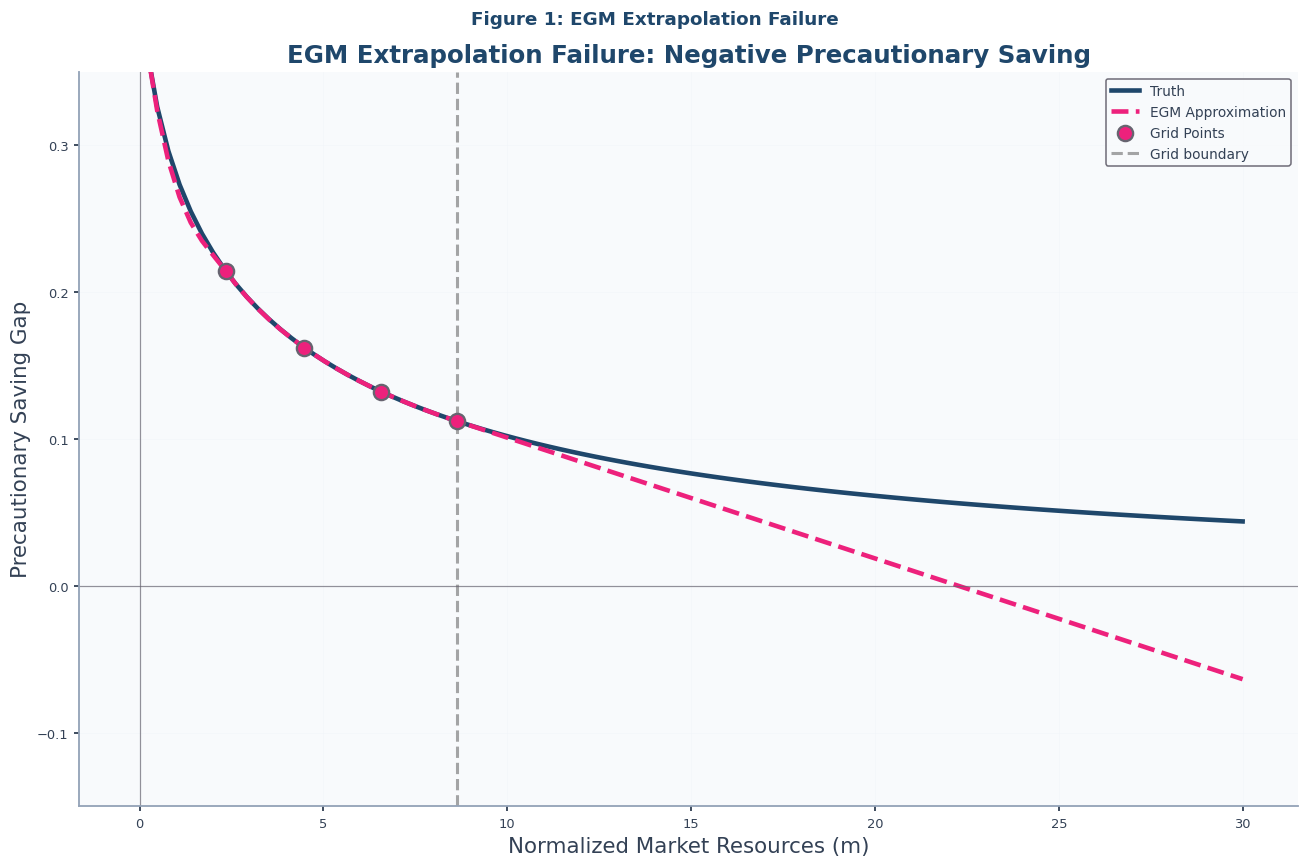

In [3]:
# | label: fig:egm-extrapolation-problem

# Figure 1: EGM Extrapolation Failure
plot_precautionary_gaps(
    truth_solution=IndShockTruthSol,
    approx_solutions=IndShockEGMApproxSol,
    title="Figure 1: EGM Extrapolation Failure",
    subtitle="EGM Extrapolation Failure: Negative Precautionary Saving",
)

```{important} EGM vs MoM Extrapolation
Figure 1 demonstrates the core difference: **EGM** can predict negative precautionary saving (violating economic theory), while **MoM** maintains positive precautionary saving through asymptotically linear extrapolation.
```

```{note} EGM in the Literature
:class: dropdown

The Endogenous Grid Method ({cite:t}`carrollEGM`) is a powerful and widely-used tool in computational economics. Its applications have been extended to solve multi-dimensional problems {cite:p}`BarillasFV2007`, models with occasionally binding constraints {cite:p}`HintermaierKoeniger2010`, non-smooth and non-concave problems {cite:p}`Fella2014`, and discrete-continuous choice models {cite:p}`IskhakovRustSchjerning2017`. For a comprehensive treatment of the theory and practice of EGM, see {cite:p}`White2015`.

A critical step in implementing any numerical solution is the discretization of continuous stochastic processes. Standard methods for discretizing income shocks include those proposed by {cite:p}`TauchenHussey1991` and {cite:p}`tauchen1986`.
```

### Figure 2: Truth Bounded by Theory

Having established the extrapolation problem, we now turn to the theoretical foundation of its solution. The Method of Moderation is built upon a crucial insight from consumption theory: the optimal consumption function for a "realist" consumer facing uncertainty is always bounded by the consumption functions of two hypothetical consumers for whom the problem has a simple, analytical solution. These are the "optimist" and the "pessimist."

This figure illustrates these theoretical bounds, demonstrating that the true, high-precision consumption function (our "Truth" solution) lies neatly between them. This provides the theoretical justification for the MoM's approach, as shown in [](#fig:truth-bounded-by-theory) (which corresponds to {ref}`Figure 2 <fig:IntExpFOCInvPesReaOptNeedHi>` in the academic paper).

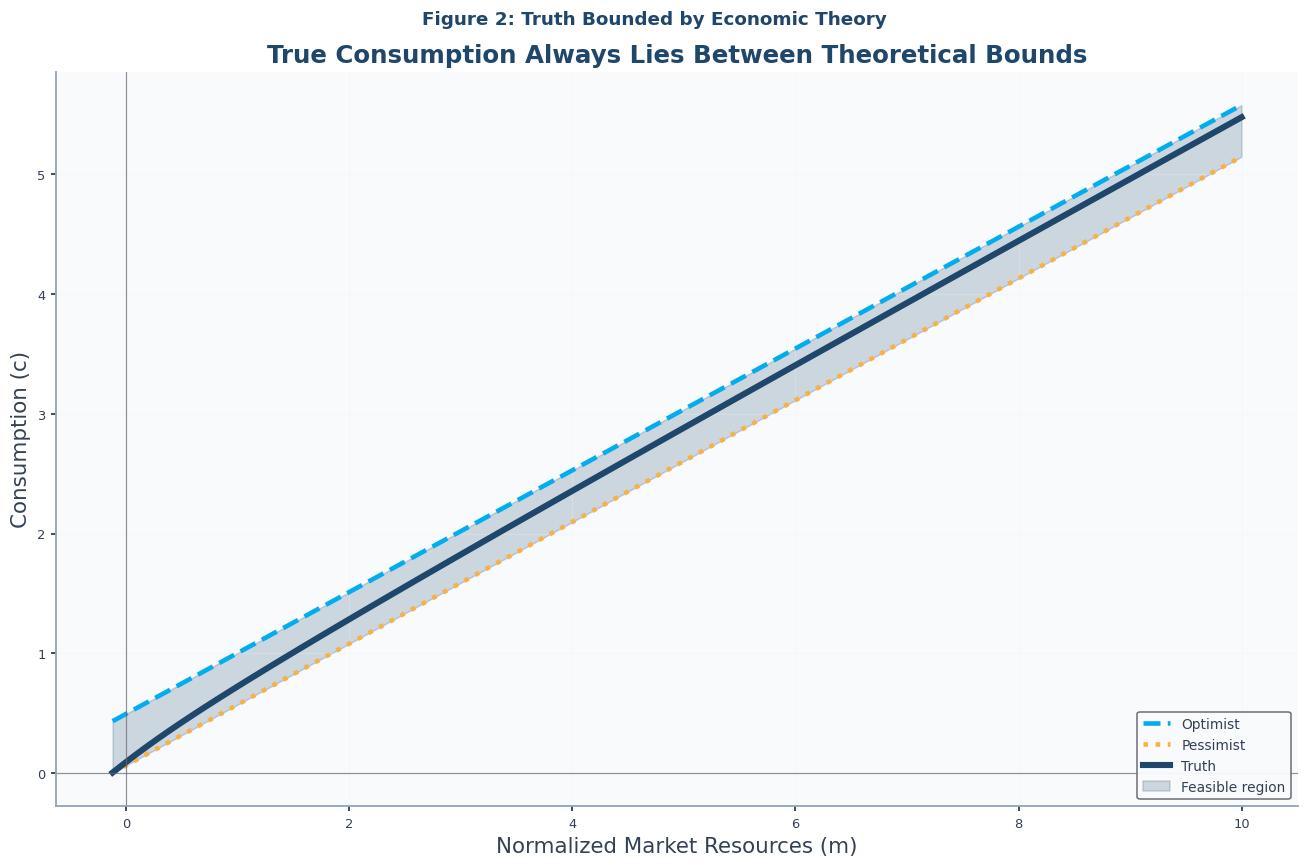

In [4]:
# | label: fig:truth-bounded-by-theory

# Figure 2: Truth Bounded by Theory
plot_consumption_bounds(
    solution=IndShockTruthSol,
    title="Figure 2: Truth Bounded by Economic Theory",
    subtitle="True Consumption Always Lies Between Theoretical Bounds",
    show_grid_points=False,  # Truth solution has too many grid points to display clearly
)

```{important} Key Theoretical Insight
The realist consumption function $\cFuncReal(\mNrm)$ lies between the optimist $\cFuncOpt(\mNrm)$ and pessimist $\cFuncPes(\mNrm)$ bounds, reflecting precautionary saving motives. This theoretical constraint, $\cFuncPes(\mNrm) \leq \cFuncReal(\mNrm) \leq \cFuncOpt(\mNrm)$, is the foundation for the Method of Moderation {cite:p}`CarrollShanker2024`. The existence of a lower bound on consumption (and thus an upper bound on borrowing) is a key result from the literature on general equilibrium models with incomplete markets {cite:p}`Aiyagari1994,Huggett1993`. This "natural borrowing constraint" arises because consumers must be able to repay their debts, which is not possible if their income can fall to a low level with positive probability. Consequently, the consumption function is not well-defined for levels of market resources below this lower bound {cite:p}`Zeldes1989,Deaton1991`.
```

### Figure 3: Method of Moderation Solution

With the theoretical bounds established, we can now demonstrate how the Method of Moderation uses them to solve the extrapolation problem. Instead of directly interpolating the consumption function, MoM interpolates a **moderation ratio** that measures where the realist's consumption lies relative to the optimist and pessimist bounds.

Because this ratio is interpolated in a transformed space that guarantees it will respect the bounds, the resulting consumption function also respects them. As this figure shows, the MoM approximation of the precautionary saving gap remains positive and closely tracks the true solution, even far beyond the computed grid. The success of this approach is clearly demonstrated in [](#fig:mom-solution) (which corresponds to {ref}`Figure 3 <fig:ExtrapProblemSolved>` in the academic paper).

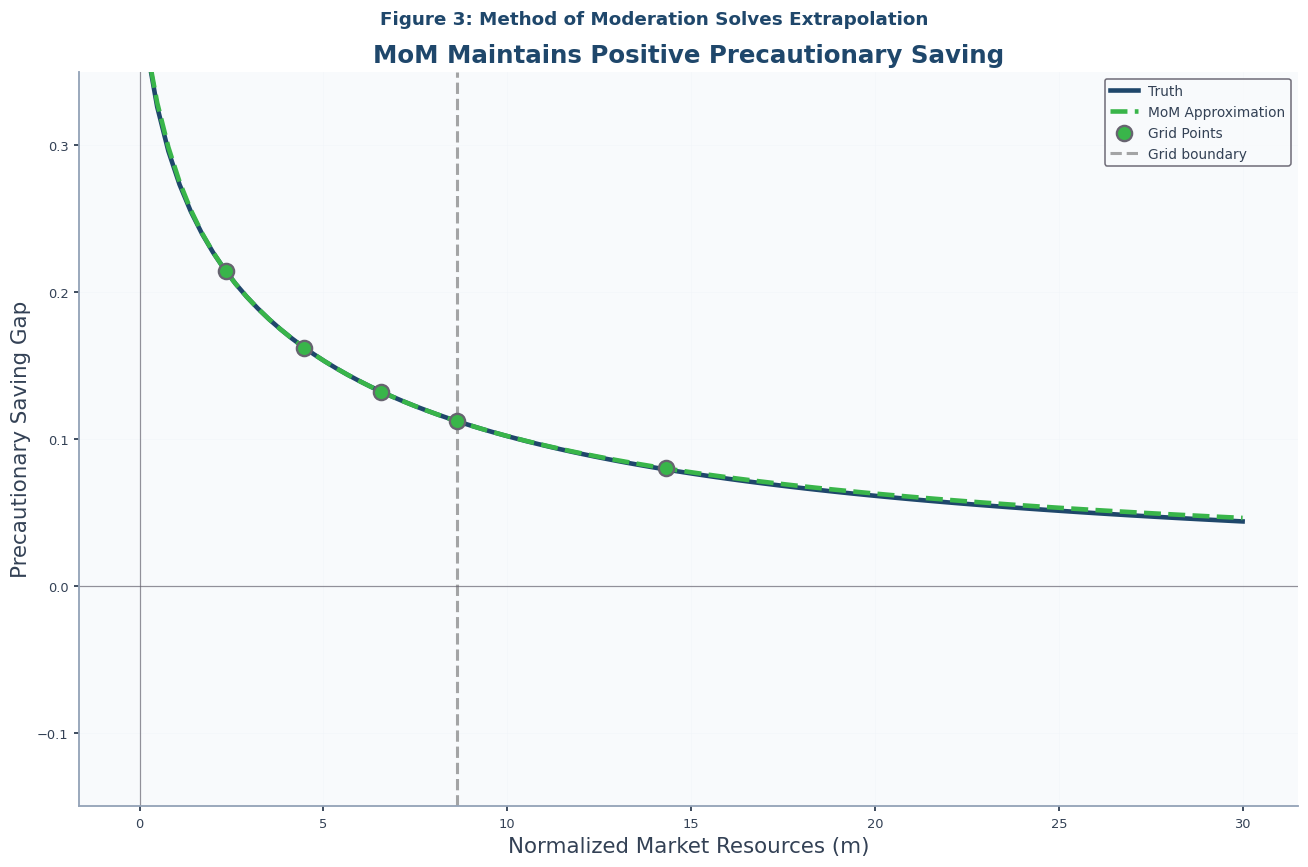

In [5]:
# | label: fig:mom-solution

# Figure 3: Method of Moderation Success
plot_precautionary_gaps(
    truth_solution=IndShockTruthSol,
    approx_solutions=IndShockMoMApproxSol,
    title="Figure 3: Method of Moderation Solves Extrapolation",
    subtitle="MoM Maintains Positive Precautionary Saving",
)

```{important} Method of Moderation Success
**Success Demonstrated**: Method of Moderation maintains positive precautionary saving even when extrapolating far beyond its computed grid range, matching the high-precision truth.
```

The Method of Moderation builds on EGM's computational strengths while addressing the extrapolation challenge through economic theory. Following [the paper's algorithm](moderation.md#the-method-of-moderation), the key insight is that optimal consumption is always bounded between the optimist and pessimist consumption functions, both of which have known analytical solutions.

(notebook:algorithm)=

```{note} MoM Algorithm Details
:class: dropdown

Instead of extrapolating consumption directly (which can violate bounds), MoM follows these steps (notation matches the paper):
1. **Solve standard EGM** to get realist consumption at gridpoints
2. **Transform to log excess resources** $\logmNrmEx = \log(\mNrm - \mNrmMin)$ for convenient interpolation domain
3. **Compute moderation ratio** $\modRte(\logmNrmEx) = \dfrac{\cFuncReal - \cFuncPes}{\hNrmEx\,\MPCmin} = \dfrac{\cFuncReal - \cFuncPes}{\cFuncOpt - \cFuncPes} \in [0,1]$ (paper Eq. {eq}`eq:modRte`)
4. **Apply standard logit transformation** $\logitModRte(\logmNrmEx) = \log(\modRte/(1-\modRte))$ for asymptotic linearity
5. **Interpolate $\logitModRte(\logmNrmEx)$ function** with derivatives for smooth extrapolation
6. **Reconstruct consumption** using $\cFuncReal = \cFuncPes + \modRte \cdot (\cFuncOpt - \cFuncPes)$

This approach ensures consumption always stays within economic bounds while achieving excellent extrapolation properties through the asymptotically linear transformation function, as {ref}`derived in the paper <the-consumption-function>`.

The quality of this method relies on accurate function approximation between gridpoints {cite:p}`Santos2000`, and the bracketing approach complements work on bounding numerical errors in dynamic models {cite:p}`JuddMaliarMaliar2017`. While linear interpolation is simple, **cubic Hermite interpolation** {cite:p}`Fritsch1980,FritschButland1984,Hyman1983` offers superior accuracy by matching not only the function's level but also its derivative at each gridpoint. This ensures that the numerical solution satisfies the Euler equation at the gridpoints themselves {cite:p}`BenvenisteScheinkman1979,MilgromSegal2002`. For even better shape-preservation, monotone cubic Hermite schemes can be employed {cite:p}`deBoor2001`. The similarity of MPCs under certain conditions {cite:p}`CKW2021Aggregation` helps explain why simpler linear bounds often perform well. The HARK toolkit implements cubic Hermite interpolation for this reason.

```

```{note} The Transformation: Mathematical Elegance
The transformation function is mathematically elegant because it transforms the bounded ratio $\modRte \in (0,1)$ into an unbounded space $\logitModRte \in (-\infty, +\infty)$. More importantly, it becomes asymptotically linear as wealth increases. In our baseline calibration, the slope $\logitModRteMu$ tends to a small positive constant (not to zero). This positive limiting slope reflects the fact that the moderation ratio $\modRte$ converges to a constant strictly between 0 and 1 as $\mNrm \to \infty$.
```

### Figure 4: MoM Consumption Function

Having shown that MoM produces a precautionary saving gap with the correct theoretical properties, we can now examine the consumption function itself. This figure plots the MoM consumption function against the same theoretical bounds we saw in Figure 2.

As expected, the MoM solution remains strictly between the optimist and pessimist bounds. The figure also introduces a **tighter upper bound**. This bound is derived from the maximum possible marginal propensity to consume ($\MPCmax$) as market resources approach the natural borrowing constraint. The existence of such a bound is a key result from the buffer-stock saving literature {cite:p}`Carroll2001MPCBound`, with explicit formulas for the limiting MPC derived in {cite:p}`MaToda2021SavingRateRich` and {cite:p}`CarrollToche2009`. The fact that the MoM solution respects this tighter bound as well, as shown in [](#fig:mom-consumption-function) (which corresponds to {ref}`Figure 4 <fig:IntExpFOCInvPesReaOptNeed45>` in the academic paper), demonstrates its robustness and theoretical consistency.

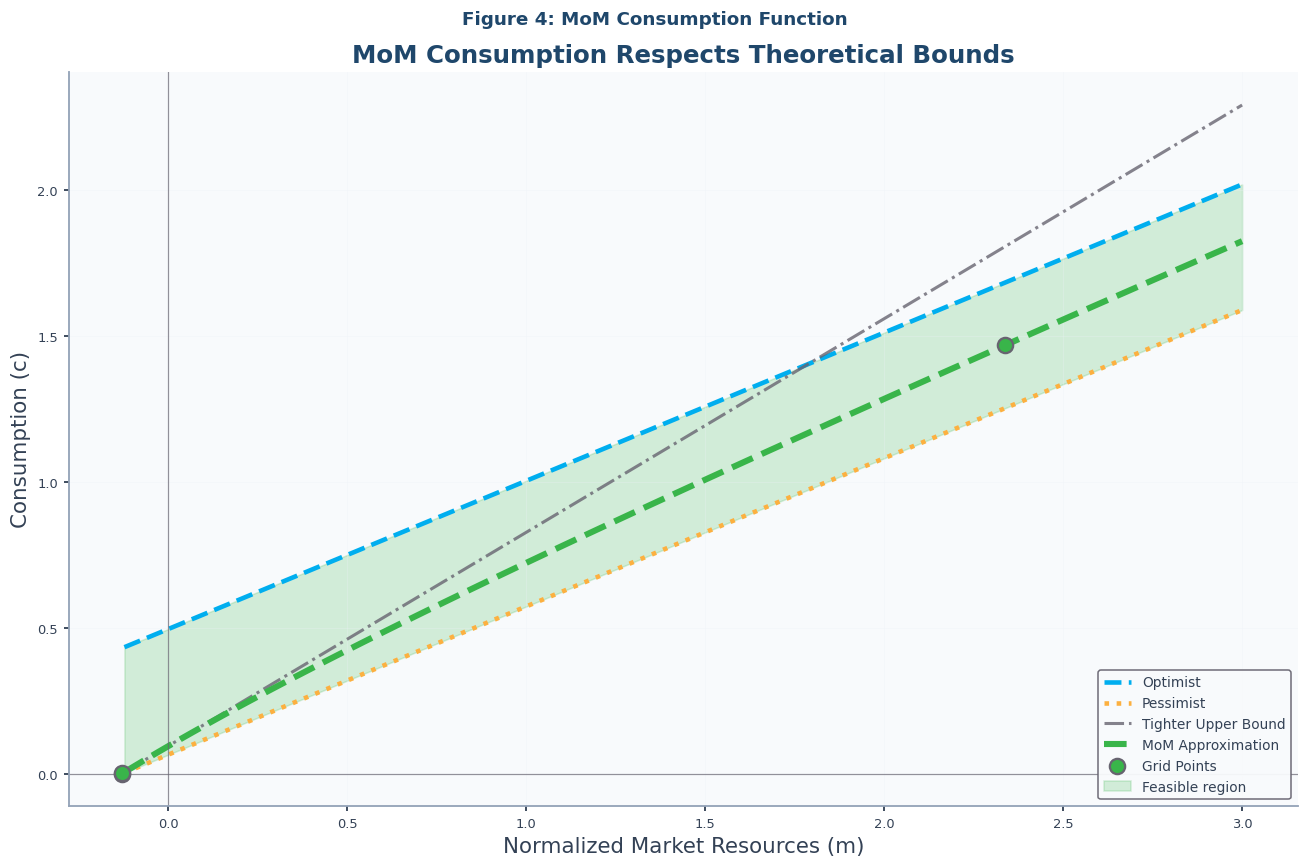

In [6]:
# | label: fig:mom-consumption-function

# Figure 4: MoM Consumption Function
plot_consumption_bounds(
    solution=IndShockMoMApproxSol,
    title="Figure 4: MoM Consumption Function",
    subtitle="MoM Consumption Respects Theoretical Bounds",
    m_max=3.0,
    show_tight_bound=True,
)

**Bound Preservation**: MoM consumption stays within theoretical bounds and below tight bound.

### Figure 5: Direct Method Comparison

We now arrive at the decisive comparison between the Endogenous Grid Method and the Method of Moderation. This figure plots the precautionary saving gaps from both the EGM and MoM solutions on the same axes, alongside the high-precision "truth" solution.

All three solutions are generated from the same underlying economic parameters, and both the EGM and MoM approximations use the same 5-point sparse grid. The difference in their extrapolation behavior is therefore entirely attributable to the solution method itself. The results, presented in [](#fig:direct-comparison), clearly show the superiority of the Method of Moderation for problems where extrapolation is a concern.

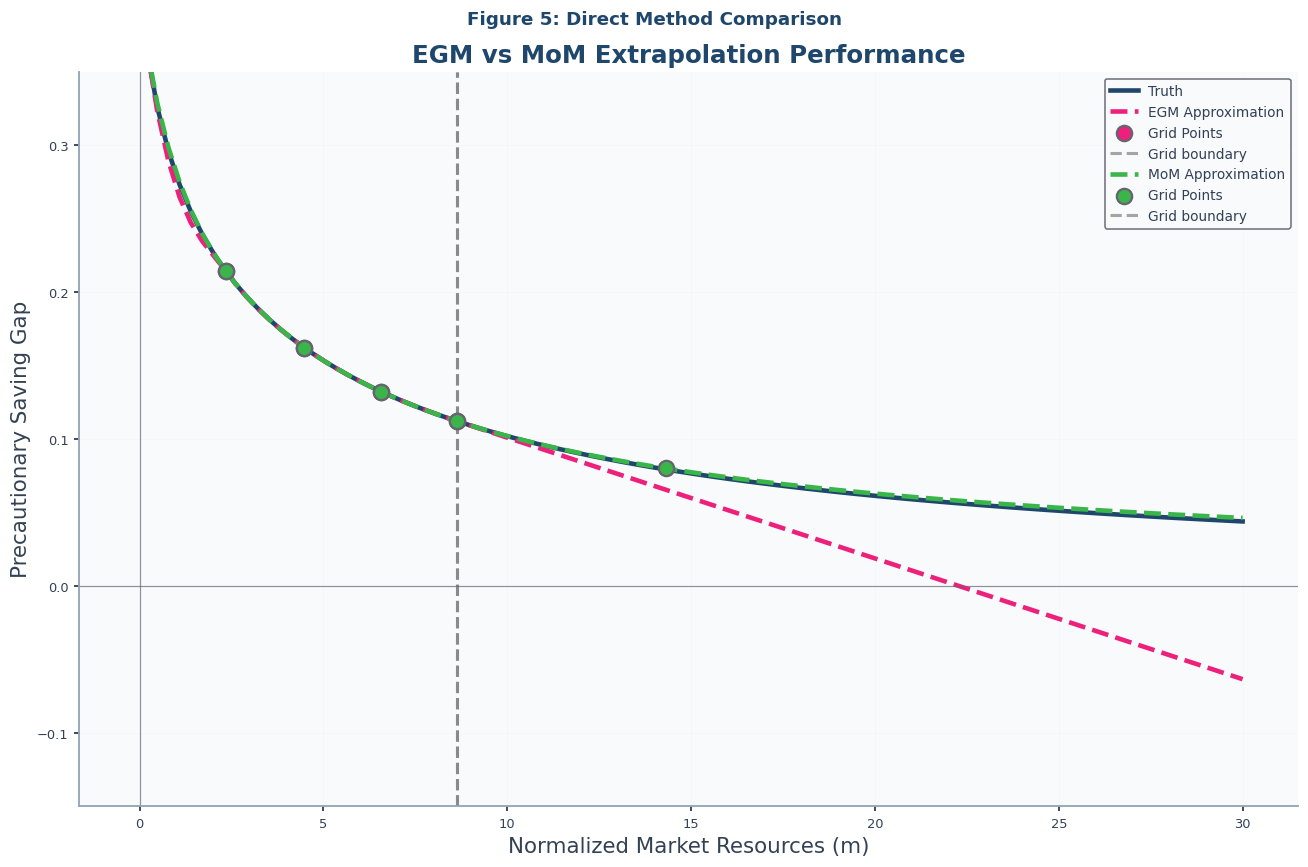

In [7]:
# | label: fig:direct-comparison

# Figure 5: Direct Method Comparison
plot_precautionary_gaps(
    truth_solution=IndShockTruthSol,
    approx_solutions=[IndShockEGMApproxSol, IndShockMoMApproxSol],
    title="Figure 5: Direct Method Comparison",
    subtitle="EGM vs MoM Extrapolation Performance",
)

```{important} The Decisive Advantage
This single figure demonstrates MoM's core advantage: given identical sparse grid data, **EGM produces economically impossible negative precautionary saving** (violating fundamental economic theory), while **MoM maintains positive precautionary saving** that closely matches the high-precision truth. The Method of Moderation solves the extrapolation problem that has long plagued sparse grid implementations of EGM.
```

## Method of Moderation Framework

### Figure 6: Moderation Ratio Function $\modRte(\mNrm)$

::::{admonition} Definition: The Moderation Ratio
:class: note

The central element of the Method of Moderation is the **moderation ratio**, $\modRte(\mNrm)$, which precisely quantifies the realist consumer's behavior relative to the theoretical bounds. Following the ML/statistics-consistent convention in equation {eq}`eq:modRte` of the paper, it is:

$$
\modRte(\mNrm) = \frac{\cFuncReal(\mNrm) - \cFuncPes(\mNrm)}{\cFuncOpt(\mNrm) - \cFuncPes(\mNrm)}
$$

This ratio is guaranteed to be strictly between 0 and 1 for all valid levels of market resources, a property that follows from the consumer's prudence (i.e., a convex marginal utility function) and the presence of bounded income shocks {cite:p}`CarrollKimball1996`. It has the following ML-consistent interpretation:

* **$\modRte = 0$**: The realist behaves like the pessimist (at low levels of wealth, maximum precautionary saving).
* **$\modRte = 1$**: The realist behaves like the optimist (at high levels of wealth, no precautionary saving).
* **$0 < \modRte < 1$**: The realist engages in a balanced moderation, reflecting partial prudence.

This figure plots the moderation ratio as a function of market resources, revealing the consumer's risk management strategy across the wealth distribution, as shown in [](#fig:moderation-ratio).
::::

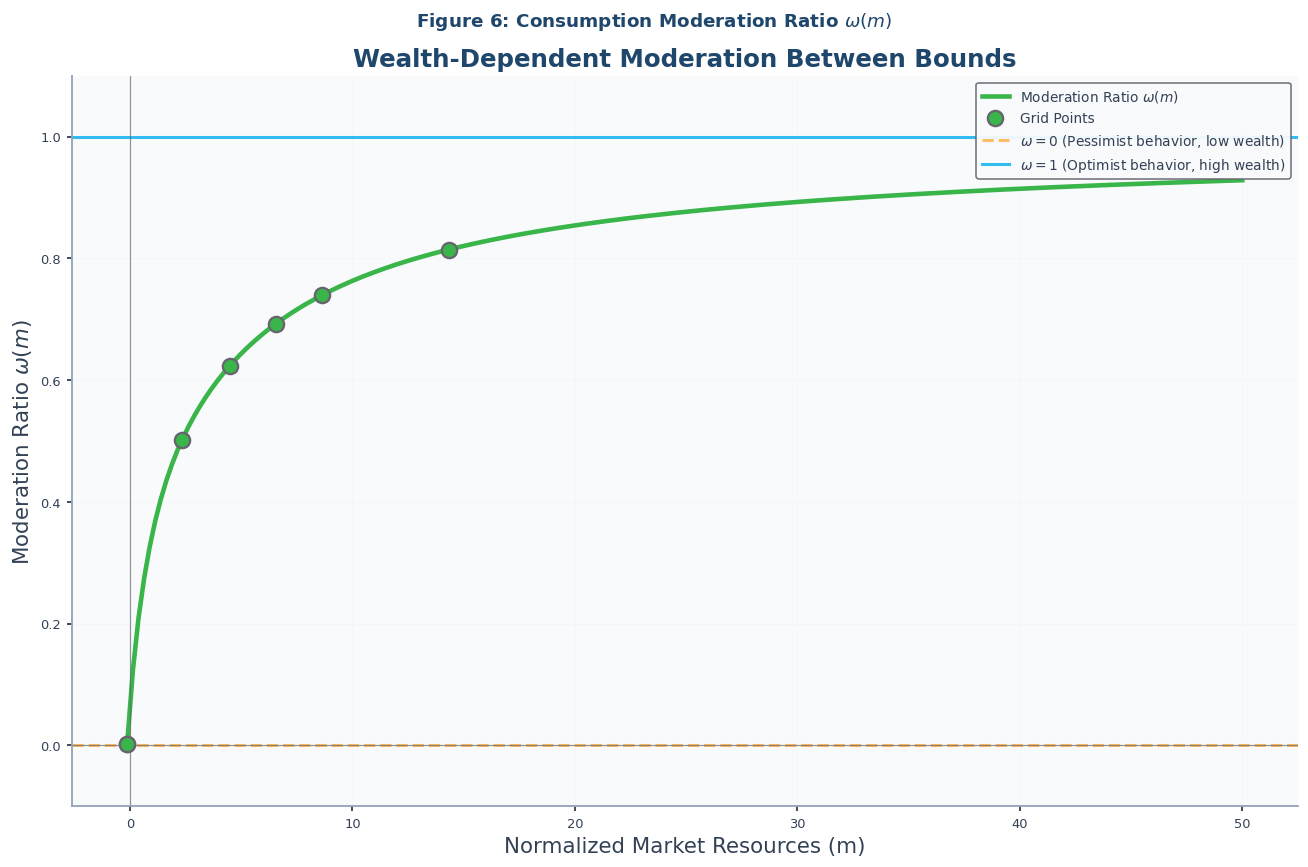

In [8]:
# | label: fig:moderation-ratio

# Figure 6: Moderation Ratio Function
plot_moderation_ratio(
    solution=IndShockMoMApproxSol,
    title=r"Figure 6: Consumption Moderation Ratio $\omega(m)$",
    subtitle="Wealth-Dependent Moderation Between Bounds",
    m_max=50,
    grid_type=GridType.CONSUMPTION,
)

```{note} Economic Interpretation of $\modRte(\mNrm)$ (ML-Consistent Convention)
The moderation ratio reveals the consumer's **risk management strategy**:

- **High wealth** ($\mNrm > 10$): $\modRte \to 1$, realist approaches optimist behavior as uncertainty becomes less important
- **Low wealth** ($\mNrm \approx \mNrmMin$): $\modRte \to 0$, realist approaches pessimist behavior due to high precautionary motives
- **Middle wealth**: $\modRte \in (0,1)$, balanced moderation reflecting partial prudence

This intuitive pattern (consistent with ML/statistics conventions) ensures that MoM consumption functions have proper economic behavior across the entire wealth distribution, unlike linear extrapolation methods that can violate economic bounds.
```

### Figure 7: The Logit Transformation

::::{admonition} Definition: The Logit Transformation
:class: note

While the moderation ratio, $\modRte(\mNrm)$, is economically intuitive, it is not ideal for numerical interpolation because it is bounded between 0 and 1. To address this, the Method of Moderation employs a **standard logit transformation**, which maps the bounded moderation ratio into an unbounded space. As defined in equation {eq}`eq:chi` of the paper, the transformed variable, $\logitModRte(\logmNrmEx)$, is:

$$
\logitModRte(\logmNrmEx) = \log\left(\frac{\modRte(\logmNrmEx)}{1 - \modRte(\logmNrmEx)}\right)
$$

where $\logmNrmEx = \log(\mNrm - \mNrmMin)$ is the log of "excess" market resources. This is the standard logit transformation used in machine learning and statistics. This transformation is the key to MoM's numerical stability and superior extrapolation properties. As [](#fig:logit-transformation) will show, the $\logitModRte$ function is nearly linear, which makes it exceptionally well-suited for interpolation.
::::

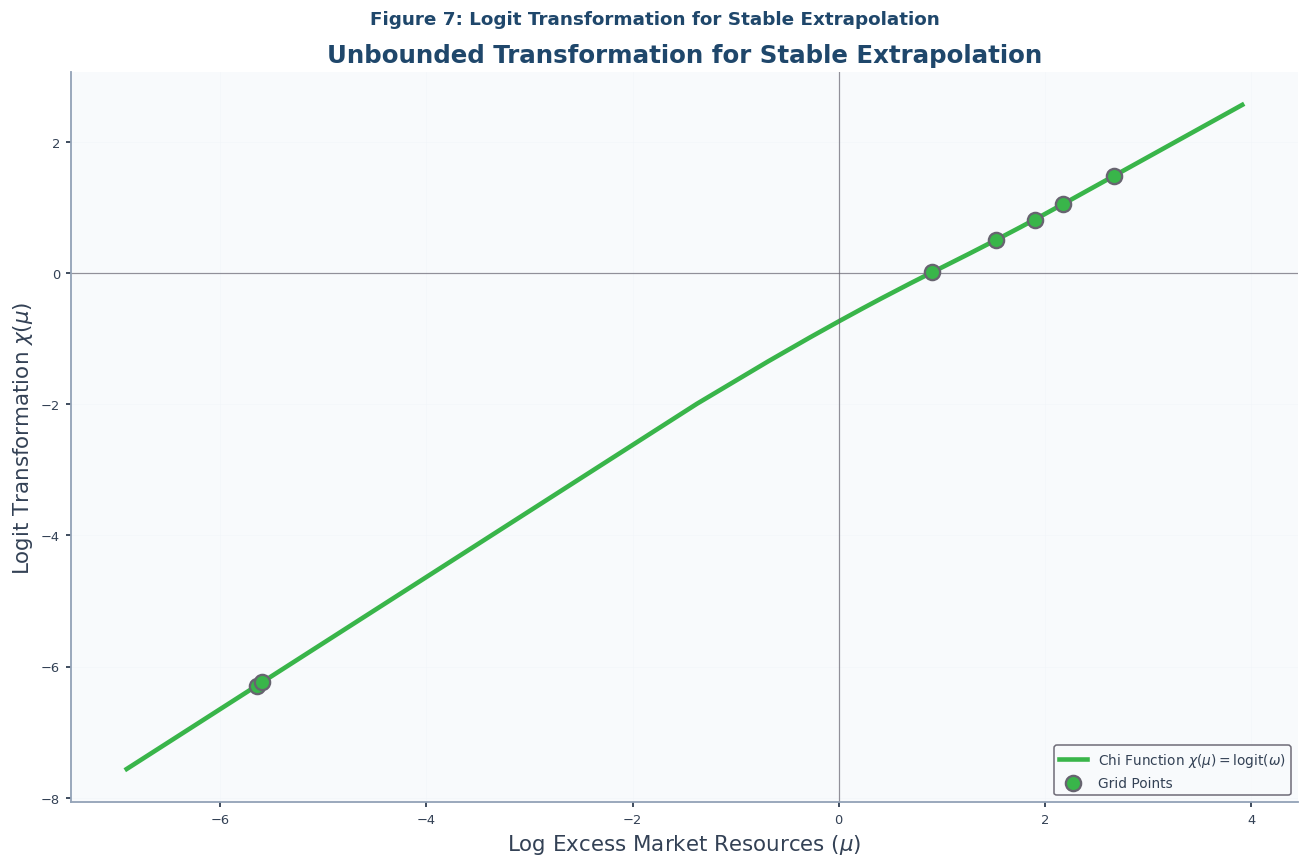

In [9]:
# | label: fig:logit-transformation

# Figure 7: Logit Transformation Function
plot_logit_function(
    solution=IndShockMoMApproxSol,
    title="Figure 7: Logit Transformation for Stable Extrapolation",
    subtitle="Unbounded Transformation for Stable Extrapolation",
    m_max=50,
)

```{important} Why Asymptotic Linearity Matters
As $\logmNrmEx \to \infty$ (high wealth), the $\logitModRte(\logmNrmEx)$ curve becomes approximately linear with a positive slope $\logitModRteMu>0$. This asymptotic linearity is crucial because:

1. **Prevents extrapolation errors**: Unlike linear methods that can predict negative precautionary saving, MoM's linear extrapolation preserves economic theory
2. **Ensures convergence**: The consumption function approaches the optimist bound smoothly without oscillation
3. **Maintains stability**: Small numerical errors don't compound into large extrapolation mistakes

This asymptotic linearity with positive slope is what prevents the extrapolation errors that plague standard endogenous grid methods.
```

```{note} Mathematical Properties of $\logitModRte(\logmNrmEx)$ (ML-Consistent Convention)
The standard logit transformation exhibits several key properties visible in the figure (with $\logitModRteMu>0$):

- **Unbounded domain**: $\logitModRte \in (-\infty, \infty)$ allows smooth interpolation without artificial constraints
- **Monotonically increasing**: Higher wealth (larger $\logmNrmEx$) corresponds to higher $\logitModRte$ values (closer to optimist behavior)
- **Asymptotic linearity with positive slope**: $\logitModRteMu>0$ as $\logmNrmEx \to \infty$, ensuring stable extrapolation
- **Economic interpretation** (ML-consistent):
  - $\logitModRte > 0$: Realist closer to optimist (low precautionary saving)
  - $\logitModRte < 0$: Realist closer to pessimist (high precautionary saving)
  - $\logitModRte \approx 0$: Balanced between extremes

This mathematical elegance translates directly into superior numerical properties for consumption function approximation and matches standard ML/statistics conventions.
```

## Function Properties and Bounds

### Figure 8: MoM MPC Bounded by Theory

Beyond the consumption function itself, its derivative—the **marginal propensity to consume (MPC)**—is of central economic importance. The MPC, $\partial c / \partial m$, measures the change in consumption for a one-unit change in market resources and is a key input for macroeconomic models and policy analysis. It is crucial for understanding:

* **Monetary policy transmission**: How interest rate changes affect spending
* **Fiscal policy effectiveness**: How tax rebates stimulate consumption
* **Wealth effects**: How asset price changes impact the economy

Just as with the consumption function, the MPC must respect theoretical bounds. As detailed in {ref}`the paper's extensions <a-tighter-upper-bound>`, the MPC is bounded by a minimum value, $\MPCmin$ (the MPC of the risk-free optimist), and a maximum value, $\MPCmax$ (the MPC as resources approach the borrowing constraint). These bounds are fundamental properties of consumption models with prudence {cite:p}`Carroll2001MPCBound`. This figure demonstrates that the MPC derived from the MoM consumption function correctly lies within these theoretical bounds, as shown in [](#fig:mpc-bounds).

```{important} Policy Applications: Why MPC Bounds Matter
In practice, bounded MPC estimates are crucial for policy analysis. If a DSGE model predicts unrealistic MPC values (>1 or <0) due to extrapolation errors, policy multipliers become nonsensical. The Method of Moderation ensures MPC values always remain economically meaningful, making it particularly valuable for Federal Reserve DSGE models used in monetary policy analysis.
```

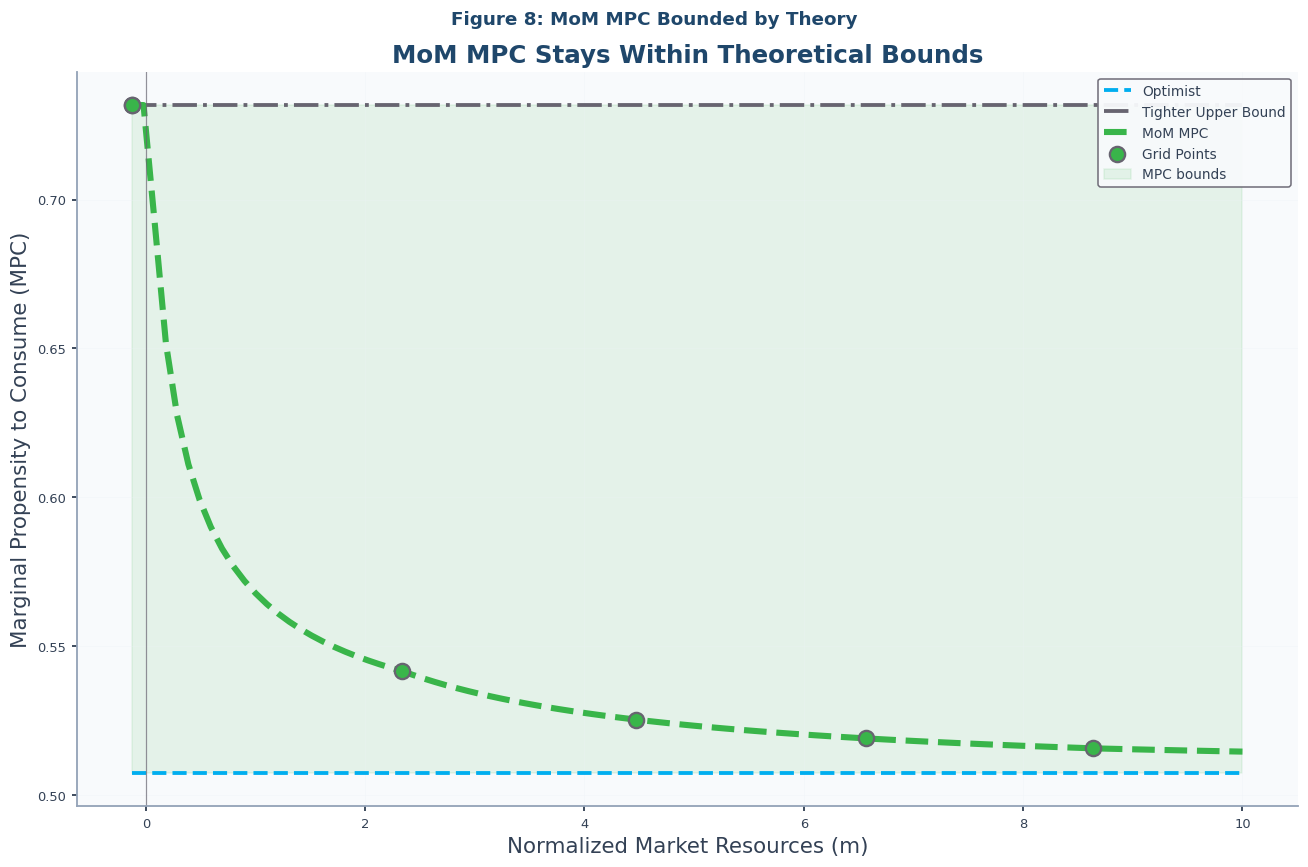

In [10]:
# | label: fig:mpc-bounds

# Figure 8: MoM MPC Bounds
plot_mom_mpc(
    solution=IndShockMoMApproxSol,
    title="Figure 8: MoM MPC Bounded by Theory",
    subtitle="MoM MPC Stays Within Theoretical Bounds",
)

```{note} MPC Economic Interpretation
**MPC Bounds Respected**: The MoM marginal propensity to consume declines with $\mNrm$ as theory predicts, staying between $\MPCmin$ and $\MPCmax$. This reflects fundamental economic principles:

* **Poor consumers** spend windfalls immediately (high $\MPC$, approaching $\MPCmax$)
* **Rich consumers** save most windfalls (low $\MPC$, approaching $\MPCmin$)
* This reflects **diminishing marginal utility** of consumption
* $\MPC$ decline shows wealth effects diminish with higher market resources
* Linear consumption functions have constant $\MPC$ reflecting perfect-foresight assumptions

The bounds ensure that $\MPC$ values remain economically sensible, with the realist $\MPC$ lying between the tight upper bound $\MPCmax$ and optimist lower bound $\MPCmin$.
```

### Figure 9: Value Functions Bounded by Theory

We now turn from the policy function, $c(m)$, to the **value function**, $v(m)$, which represents the consumer's expected lifetime utility as a function of current market resources. The value function is a cornerstone of dynamic programming and provides a comprehensive measure of a consumer's well-being.

This figure serves two purposes. First, it demonstrates that the value function, like the consumption function, is bounded by the optimist and pessimist solutions {cite:p}`Aiyagari1994,Huggett1993`. Second, it compares the value functions generated by the high-precision "truth" model, the sparse-grid EGM, and the sparse-grid MoM. This allows us to see how accurately each method approximates the true value function, as shown in [](#fig:value-functions).

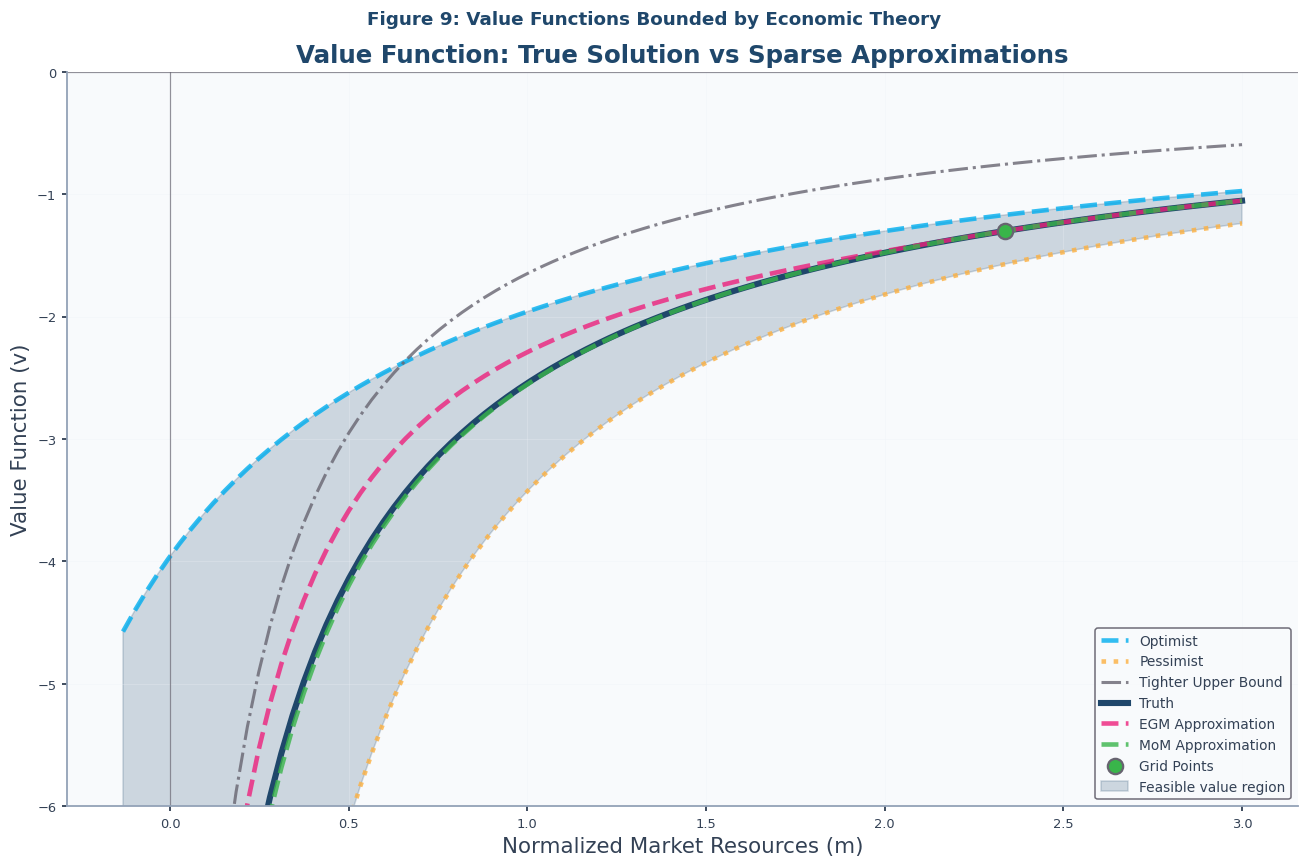

In [11]:
# | label: fig:value-functions

# Figure 9: Value Functions
plot_value_functions(
    truth_solution=IndShockTruthSol,
    title="Figure 9: Value Functions Bounded by Economic Theory",
    subtitle="Value Function: True Solution vs Sparse Approximations",
    egm_solution=IndShockEGMApproxSol,
    mom_solution=IndShockMoMApproxSol,
)

```{note} Value Function Economic Interpretation
This figure shows the **theoretical bounds**, **sparse approximations**, and **truth solution**:

- **Truth** (blue) - realist solution with uncertainty
- **Optimist** (light blue) - highest possible utility
- **Pessimist** (yellow) - lowest possible utility
- **Tighter Upper Bound** (orange) - refined upper bound using maximum MPC
- **EGM Approximation** (pink) - sparse grid approximation
- **MoM Approximation** (green) - Method of Moderation approximation with visible grid points

Both EGM and MoM approximations use the same 5 sparse grid points, but MoM provides superior approximation quality, staying closer to the truth solution while respecting all theoretical bounds. The grid points (shown only for MoM to avoid duplication) reveal exactly where the sparse interpolation nodes are located, demonstrating the efficiency of the Method of Moderation approach.

The gap between optimist and pessimist values represents the **cost of uncertainty** - how much lifetime utility is reduced when facing income uncertainty rather than perfect foresight.
```

```{note} Economic Insight: The Value of Certainty
The gap between optimist and pessimist value functions reflects a fundamental economic principle: uncertainty matters most for those with little wealth. For poor consumers, income uncertainty dramatically affects optimal choices and reduces lifetime utility significantly. For wealthy consumers, large asset buffers provide natural insurance, making the difference between best-case and worst-case scenarios less pronounced. This explains why wealth inequality amplifies the welfare costs of economic uncertainty.
```

### Figure 10: Inverse Value Functions $\vInv(\mNrm)$

For numerical stability and easier interpretation, it is often convenient to work with the **inverse value function**, $\vInv(\mNrm) = \uFunc^{-1}(\vFunc(\mNrm))$. This function represents the constant level of consumption that would yield the same lifetime utility as the value function at a given level of market resources. It can be thought of as the "consumption equivalent" of lifetime utility.

This transformation is particularly useful because, as this figure shows, it tends to be much more linear than the value function itself, especially near the borrowing constraint. This makes it better suited for numerical interpolation and is a key reason for its use in HARK. This figure compares the inverse value functions from our three solutions, again demonstrating the accuracy of the MoM approximation, as shown in [](#fig:inverse-value-functions).

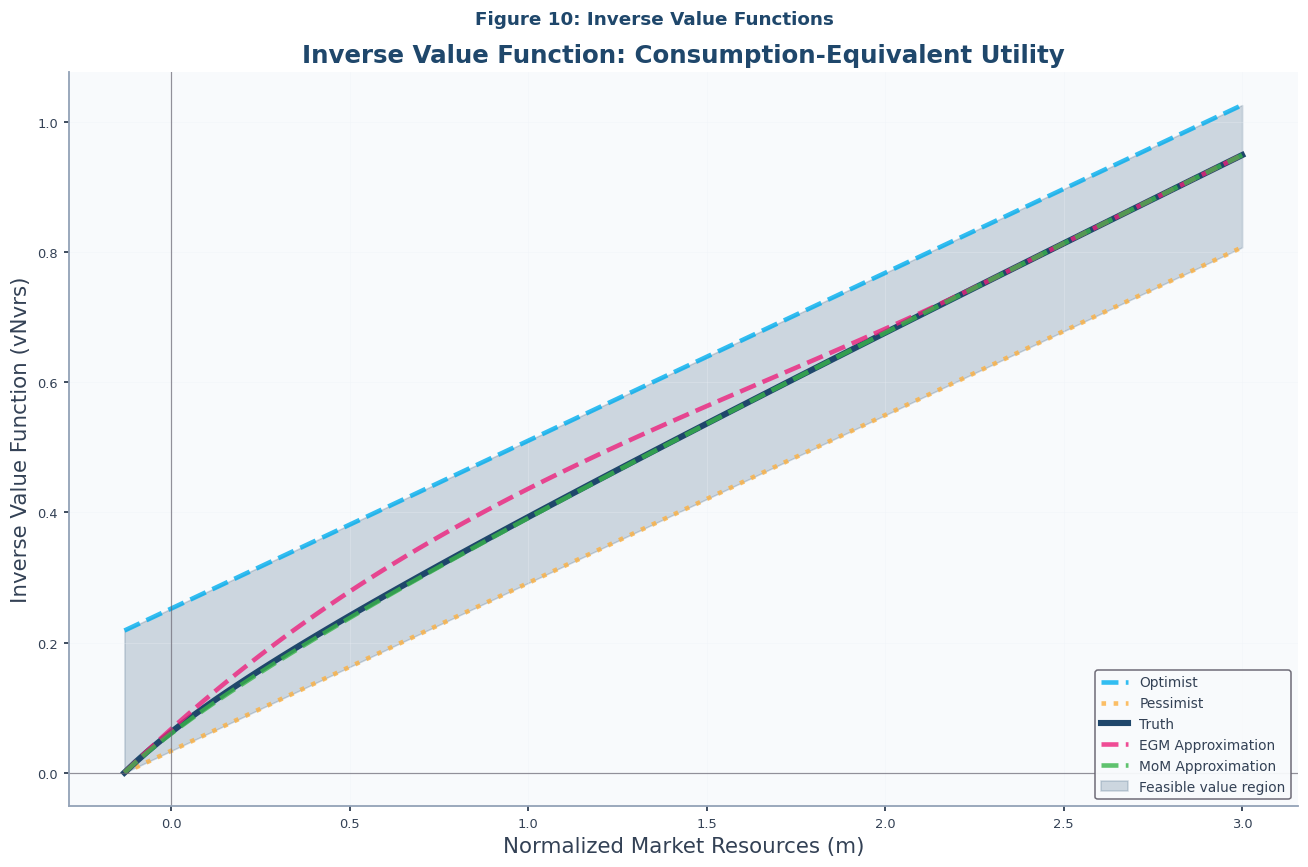

In [12]:
# | label: fig:inverse-value-functions

# Figure 10: Inverse Value Functions
plot_value_functions(
    truth_solution=IndShockTruthSol,
    title="Figure 10: Inverse Value Functions",
    subtitle="Inverse Value Function: Consumption-Equivalent Utility",
    inverse=True,
    egm_solution=IndShockEGMApproxSol,
    mom_solution=IndShockMoMApproxSol,
)

```{note} Inverse Value Function Economic Interpretation
The inverse value functions provide an intuitive consumption-equivalent interpretation of lifetime utility:

- **Truth** (blue) - consumption equivalent of realist lifetime utility
- **Optimist** (light blue) - consumption equivalent with no uncertainty
- **Pessimist** (yellow) - consumption equivalent with worst-case scenarios
- **EGM Approximation** (pink) - sparse grid approximation
- **MoM Approximation** (green) - Method of Moderation approximation

The inverse transformation $\vInv(\mNrm) = \uFunc^{-1}(\vFunc(\mNrm))$ converts utility units into consumption units, making the economic interpretation more intuitive. For example, if $\vInv(5) = 0.8$, then having 5 units of wealth provides the same lifetime utility as consuming 0.8 units forever.

The ordering and gaps between inverse value functions mirror those in Figure 8, but the inverse transformation linearizes the problem near the borrowing constraint, which is why HARK uses this representation for numerical interpolation.
```

### Figure 11: Value Function Moderation Ratio

The final figure demonstrates the versatility of the Method of Moderation. Because the method is built on the general principle of moderating between theoretical bounds, it can be applied not just to the consumption function, but to any function that is similarly bounded. Here, we apply it to the **inverse value function**.

The moderation ratio for the inverse value function is defined analogously to the consumption moderation ratio (following the ML-consistent convention):

$$
\valModRte(\mNrm) = \frac{\vInvReal(\mNrm) - \vInvPes(\mNrm)}{\vInvOpt(\mNrm) - \vInvPes(\mNrm)}
$$

This ratio measures how the realist's inverse value function relates to the theoretical bounds, with $\valModRte = 0$ at low wealth (pessimistic) and $\valModRte = 1$ at high wealth (optimistic). As the figure shows, the pattern is similar to that of the consumption moderation ratio, providing further evidence of the robustness of the Method of Moderation, as shown in [](#fig:value-moderation-ratio).

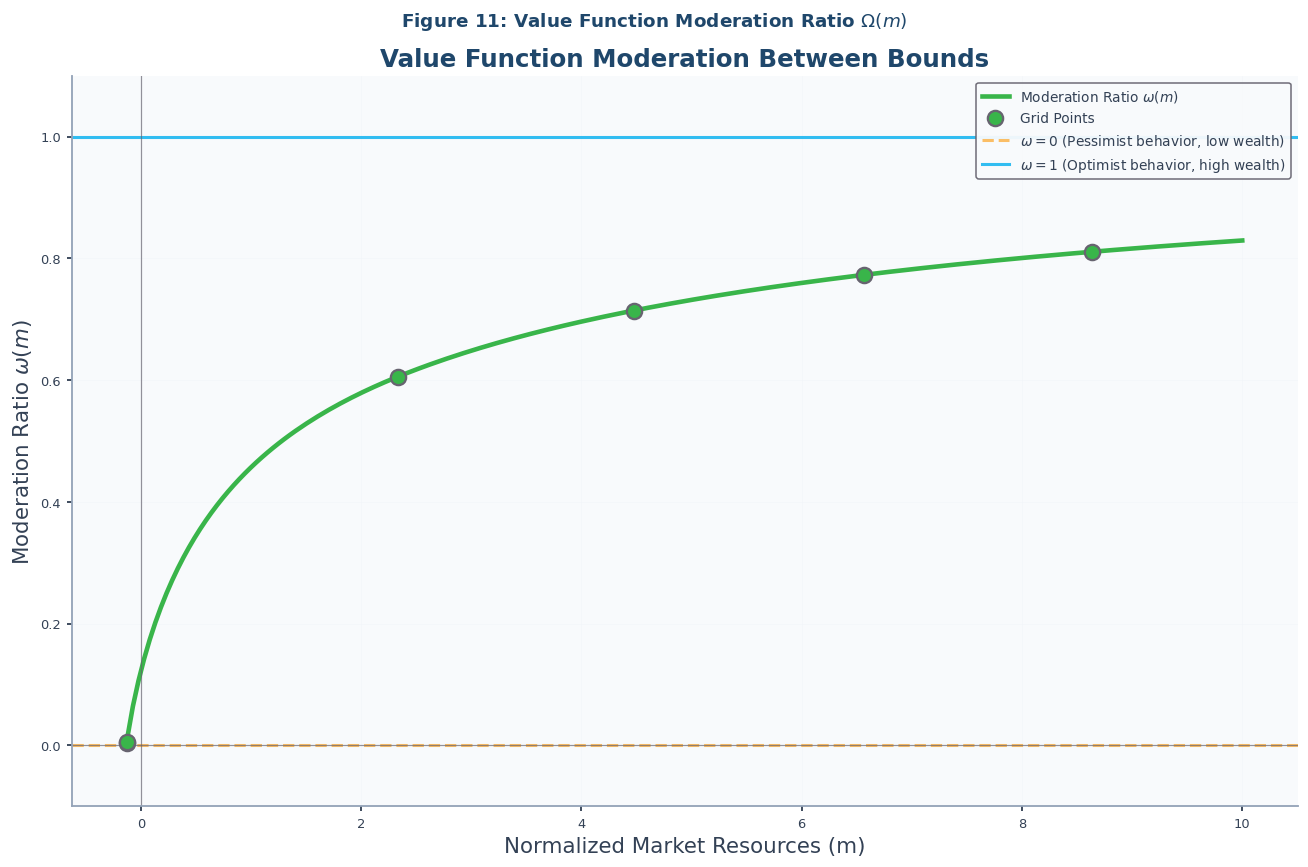

In [13]:
# | label: fig:value-moderation-ratio

# Figure 11: Value Function Moderation Ratio
plot_moderation_ratio(
    solution=IndShockMoMApproxSol,
    title=r"Figure 11: Value Function Moderation Ratio $\Omega(m)$",
    subtitle="Value Function Moderation Between Bounds",
    m_max=10,
    grid_type=GridType.VALUE,
)

```{note} Value Function Moderation Interpretation
The value function moderation ratio reveals how **uncertainty affects lifetime utility**:

- **High wealth** ($\mNrm > 10$): $\valModRte \to 0$, realist inverse value approaches optimist inverse value as uncertainty becomes less costly
- **Low wealth** ($\mNrm \approx \mNrmMin$): $\valModRte \to 1$, realist inverse value approaches pessimist inverse value due to high uncertainty costs
- **Middle wealth**: $\valModRte \in (0,1)$, balanced assessment of uncertainty's utility impact on inverse values

This pattern shows that uncertainty's welfare cost diminishes with wealth, providing economic insight into the distributional effects of uncertainty.
```

## Further Extensions: Stochastic Rate of Return

The analysis so far has assumed a constant, risk-free interest rate. The Method of Moderation can be extended to incorporate a stochastic rate of return on assets. In the case where the rate of return is independently and identically distributed (i.i.d.), the classic work of {cite:t}`Samuelson1969` and {cite:t}`Merton1969,Merton1971` shows that the consumption function remains linear for a consumer with no labor income, with a constant MPC that depends on the distribution of returns.

This result allows the MoM framework to be applied directly, simply by substituting the stochastic-return MPC for the perfect-foresight MPC in the definition of the optimist's consumption function. As wealth becomes very large, the consumption function becomes asymptotically linear as the precautionary motive related to labor income vanishes {cite:p}`BBZ2016SkewedWealth`. For a detailed derivation, see {cite:t}`CRRA-RateRisk`. The more complex case of serially correlated returns is a topic for future research.

## Summary: Why the Method of Moderation Matters

This notebook has demonstrated the Method of Moderation from both a practical and a theoretical perspective. We began by showing that the standard Endogenous Grid Method, while computationally efficient, can produce economically nonsensical results when extrapolating from a sparse grid. We then introduced the theoretical underpinnings of MoM, which is built on the insight that the true consumption function is always bounded by analytical optimist and pessimist solutions.

The core innovation of the Method of Moderation is to solve the model in a transformed space defined by these bounds. By interpolating a **moderation ratio** via an asymptotically linear **logit transformation**, MoM ensures that its solutions respect theoretical constraints by construction. This approach not only solves the extrapolation problem but also provides a robust and efficient method for solving consumption-saving models.

**Key Advantages**:

* **Theoretical Consistency**: Solutions always respect economic bounds, preventing issues like negative precautionary saving.
* **Numerical Stability**: The use of transformations and analytical bounds leads to robust and accurate solutions.
* **Computational Efficiency**: MoM builds upon the speed of EGM, adding only a small computational overhead.

These features make the Method of Moderation a powerful tool for a wide range of applications, from academic research to policy analysis in central banks and other institutions.

For complete theoretical development see {ref}`the-method-of-moderation`.

```